# Case Study 4 - Validating gridded data products
## Description 
As a user of spatial data products (satellite or modelled), I want to compare high-quality ground-based data from multiple sites with the product, so that I can assess its precision and accuracy for estimating the same variables at other sites.
## Case Breakdown 
- **Actors:** Gridded Data User
- **Goals:** Finding correlations between gridded data and ground-based data
- **Scope:** National, point-based
## Generalised case
I want to compare measurements from a gridded data product with actual on-ground measurements from different sites and report mean and standard deviation for the error.
## Comparable cases
- I want to compare local weather station values at APPN and/or TERN sites with the associated daily measurememts from national weather datasets (BOM).
## Stakeholders 
- **Name:** Donald Hobern
- **Contact:** donald.hobern@adelaide.edu.au


## Data Sources
The case study uses national weather data products from the Bureau of Meteorology for daily mean minimum/minimum temperature, accessible from http://www.bom.gov.au/jsp/awap/temp/index.jsp. Seven daily maximum and minimum temperature grids were downloaded for the dates 7 to 13 April 2025 inclusive. These data can be accessed in the source_data folder in the downloaded ASCII grid format (\*.grid). These data will be loaded into the data cube as WGS84 Geotiff files. To avoid extra dependencies in this notebook, the data have already been converted using QGIS Desktop and are also included in the source_data folder (\*.tiff).

Comparison data for maximum and minimum air temperature were downloaded for all public weather stations in Western Australia from https://weather.agric.wa.gov.au/ for the 10 day period 4 to 13 April 2025. These are included in source_data as CSV files. These downloads do not include the coordinates for the weather stations. These were downloaded via the https://api.agric.wa.gov.au/v2/weather/openapi/#/Stations/getStations API method and are included in source_data as DPIRD_weather_stations.json.

## Imports

In [44]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 
import shutil
import subprocess
import json
import os

from stac_generator.factory import StacGeneratorFactory
from stac_generator.core.base.generator import StacSerialiser
from stac_generator.core.base.schema import StacCollectionConfig, ColumnInfo
from stac_generator.core.raster.schema import RasterConfig, BandInfo
from stac_generator.core.vector.schema import VectorConfig
from stac_generator.core.point.schema import PointConfig

from mccn.client import MCCN

from xarray.groupers import TimeResampler

## Data Paths

In [45]:
# Paths to current folder and scratch folder for working files
current_folder = Path.cwd()
source_folder = current_folder / "source_data"
scratch_folder = current_folder/"scratch"
if not scratch_folder.exists():
    scratch_folder.mkdir()


# Paths to data from weather stations
weather_stations = source_folder/ "DPIRD_weather_stations.json"
weather_maxima_source = source_folder/ "10DAY_MAX_AIRTEMPERATURE_20250414162054.csv"
weather_minima_source = source_folder/ "10DAY_MIN_AIRTEMPERATURE_20250414162111.csv"

# Paths for outputs merging coordinates and CSV data for weather stations
weather_maxima = scratch_folder/ "weather_maximum_readings.csv"
weather_minima = scratch_folder/ "weather_minimum_readings.csv"

# Lists of paths for Geotiffs from BOM data
maxima_layers = {f.name: f for f in source_folder.iterdir() if not f.is_dir() and f.name.startswith("mean_max") and f.name.endswith(".tiff")}
minima_layers = {f.name: f for f in source_folder.iterdir() if not f.is_dir() and f.name.startswith("mean_min") and f.name.endswith(".tiff")}

## Prepare weather station data
Read coordinates from JSON weather station metadata. Join these coordinates with the maximum and minimum air temperature readings. Drop values for the three dates preceding the BOM layers. Reshape the data to one value per row. Save using the output paths.

In [46]:
# Get station coordinates as dataframe
station_columns = ["Name", "Latitude", "Longitude"]
stations = []
with open(weather_stations) as stations_file:
    stations_data = json.load(stations_file)
    for s in stations_data["collection"]:
        stations.append({"Name": f"{s['stationName']} ({s['stationCode']})", "Latitude": s["latitude"], "Longitude": s["longitude"]})
df_station = pd.DataFrame(columns=station_columns, data=stations)

# Process maximum air temperature data
df_maxima = pd.merge(df_station, pd.read_csv(weather_maxima_source), how="left", on="Name")
df_maxima = df_maxima.drop(columns=["04/04", "05/04", "06/04"])
df_maxima = df_maxima.rename(columns={c: f"2025-{c[3:]}-{c[0:2]}T12:00:00Z" for c in df_maxima.columns if c.endswith("04")})
df_maxima = pd.melt(df_maxima, id_vars=["Name", "Latitude", "Longitude"], var_name="Date", value_name="MaxTemp").reset_index()
df_maxima.to_csv(weather_maxima, index=False)

# Process minimum air temperature data
df_minima = pd.merge(df_station, pd.read_csv(weather_minima_source), how="left", on="Name")
df_minima = df_minima.drop(columns=["04/04", "05/04", "06/04"])
df_minima = df_minima.rename(columns={c: f"2025-{c[3:]}-{c[0:2]}T12:00:00Z" for c in df_minima.columns if c.endswith("04")})
df_minima = pd.melt(df_minima, id_vars=["Name", "Latitude", "Longitude"], var_name="Date", value_name="MinTemp").reset_index()
# Unavailable values are mostly represented by empty strings, but sometime by a hyphen.
df_minima = df_minima.drop(df_minima[df_minima["MinTemp"] == "-"].index)
df_minima.to_csv(weather_minima, index=False)


## Generate configuration files for STAC collection

Dynamically generate STAC configuration for the whole collection and for all maximum and minimum Geotiffs and for the point data files

In [47]:
# Configuration for collection as a whole.
collection_config = StacCollectionConfig(
    id="TemperatureStudy",
    title="Datasets for national temperature data validation study",
    description="STAC records for accessing datasets to explore as part of the MCCN case study 4 relating to comparisons between national temperature data products and local weather stations",
    license="CC-BY-4.0",
)

# Configurations for:
# 1) seven gridded maximum temperature layers
# 2) seven gridded minimum temperature layers
# 3) point data and site names for maximum temperature
# 4) point data for minimum temperature
configurations = [
    RasterConfig(
        id=f.split(".")[0],
        location=p.as_posix(),
        collection_date=f"{f[9:13]}-{f[13:15]}-{f[15:17]}",
        collection_time=f"12:00:00",
        band_info=[
            BandInfo(name="max_temp_gridded", description=f)
        ]
    ) for f, p in maxima_layers.items()
] + [
    RasterConfig(
        id=f"Minimum {f.split('.')[0]}",
        location=p.as_posix(),
        collection_date=f"{f[9:13]}-{f[13:15]}-{f[15:17]}",
        collection_time=f"12:00:00",
        band_info=[
            BandInfo(name="min_temp_gridded", description=f)
        ]
    ) for f, p in minima_layers.items()
] + [
    PointConfig(
        id="WeatherStationMaxima",
        location=weather_maxima.as_posix(),
        collection_date="2024-12-31",
        collection_time="00:00:00",
        X="Longitude",
        Y="Latitude",
        T="Date",
        column_info=[
            ColumnInfo(name="MaxTemp", description=f"Weather station data"),
            ColumnInfo(name="Name", description=f"Weather station data"),
        ]
    ),
] + [
    PointConfig(
        id="WeatherStationMinima",
        location=weather_minima.as_posix(),
        collection_date="2024-12-31",
        collection_time="00:00:00",
        X="Longitude",
        Y="Latitude",
        T="Date",
        column_info=[
            ColumnInfo(name="MinTemp", description=f"Weather station data"),
        ]
    ),
]

# Build the generator using the configurations.
generator = StacGeneratorFactory.get_collection_generator(
    source_configs=configurations,
    collection_config=collection_config
)

# Serialise the STAC collection. This will generate the collection JSON file and item JSON files for each layer.
serialiser = StacSerialiser(generator, scratch_folder.as_posix())
serialiser()

2025-05-02T10:05:15-stac_generator.core.raster.generator - INFO - Reading raster asset: mean_max_2025040720250407
2025-05-02T10:05:15-stac_generator.core.raster.generator - INFO - Reading raster asset: mean_max_2025040820250408
2025-05-02T10:05:15-stac_generator.core.raster.generator - INFO - Reading raster asset: mean_max_2025040920250409
2025-05-02T10:05:15-stac_generator.core.raster.generator - INFO - Reading raster asset: mean_max_2025041020250410
2025-05-02T10:05:15-stac_generator.core.raster.generator - INFO - Reading raster asset: mean_max_2025041120250411
2025-05-02T10:05:15-stac_generator.core.raster.generator - INFO - Reading raster asset: mean_max_2025041220250412
2025-05-02T10:05:15-stac_generator.core.raster.generator - INFO - Reading raster asset: mean_max_2025041320250413
2025-05-02T10:05:15-stac_generator.core.raster.generator - INFO - Reading raster asset: Minimum mean_min_2025041320250413
2025-05-02T10:05:15-stac_generator.core.raster.generator - INFO - Reading raster

## Load data into data cube
Import the data cube using a 1000*1000 grid. Group the data for the seven days as the time dimension.

In [48]:
# Load using the locally generated collection
endpoint = os.path.join(scratch_folder, "collection.json")
client = MCCN(endpoint, shape=(1000,1000), nodata={"Name": 0}, nodata_fallback=np.nan)
ds = client.load()

# Mask the 9999 nodata value in the source data
ds["max_temp_gridded"] = ds["max_temp_gridded"].where(ds["max_temp_gridded"] < 100, np.nan)
ds["min_temp_gridded"] = ds["min_temp_gridded"].where(ds["min_temp_gridded"] < 100, np.nan)
ds = ds.where(ds > -99, np.nan)

# Group layers by calendar days (timestamps do not match completely) and restrict to target dates
ds = ds.resample(time="1D").max()
#ds = ds.sel(time=slice("2025-04-07", "2025-04-13"))


# Display
ds

<xarray.Dataset> Size: 280MB
Dimensions:           (time: 7, y: 1000, x: 1000)
Coordinates:
  * y                 (y) float64 8kB -9.968 -10.0 -10.04 ... -44.45 -44.48
  * x                 (x) float64 8kB 112.0 112.0 112.1 ... 156.1 156.2 156.2
    spatial_ref       int32 4B 4326
  * time              (time) datetime64[ns] 56B 2025-04-07 ... 2025-04-13
Data variables:
    max_temp_gridded  (time, y, x) float64 56MB nan nan nan ... 14.62 14.62
    min_temp_gridded  (time, y, x) float64 56MB nan nan nan ... 16.01 16.01
    MaxTemp           (time, y, x) float64 56MB nan nan nan nan ... nan nan nan
    Name              (time, y, x) float64 56MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    MinTemp           (time, y, x) float64 56MB nan nan nan nan ... nan nan nan
Attributes:
    Name:     {0: 'nodata', 1: 'Allanooka (AN001)', 2: 'Amelup (AM001)', 3: '...

## DataCube contents
Daily mean maximum temperatures from BOM.

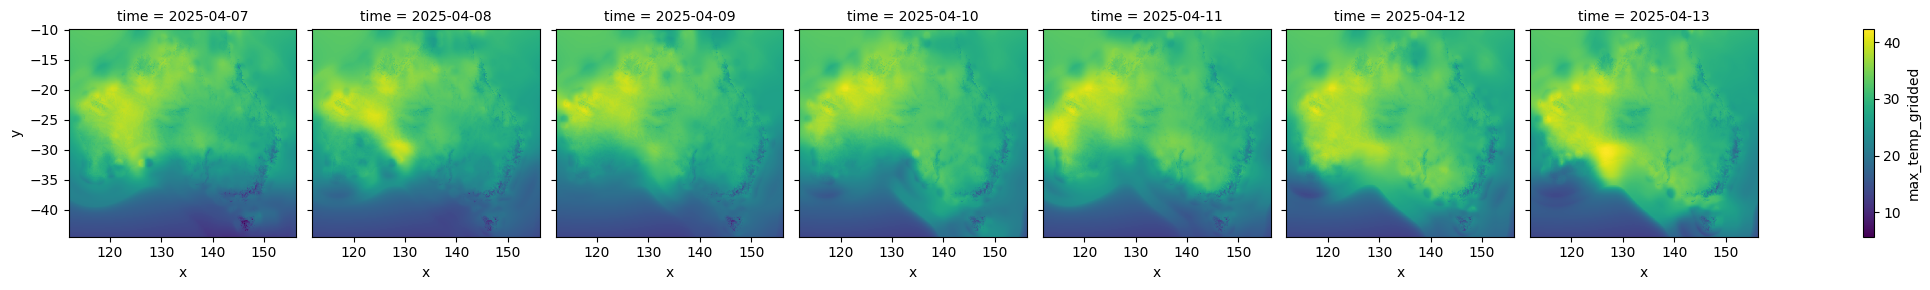

In [49]:
ds["max_temp_gridded"].plot(x="x", y="y", col="time", col_wrap=7)

Daily mean minimum temperatures from BOM.

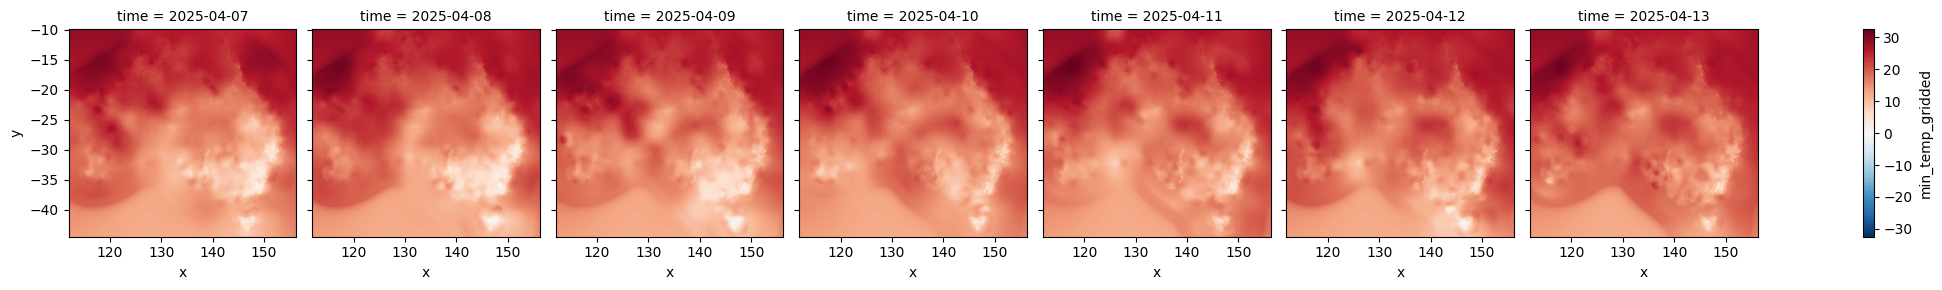

In [50]:
ds["min_temp_gridded"].plot(x="x", y="y", col="time", col_wrap=7)

Daily maximum air temperatures from weather stations (coarsened to 100*100 so values are visible).

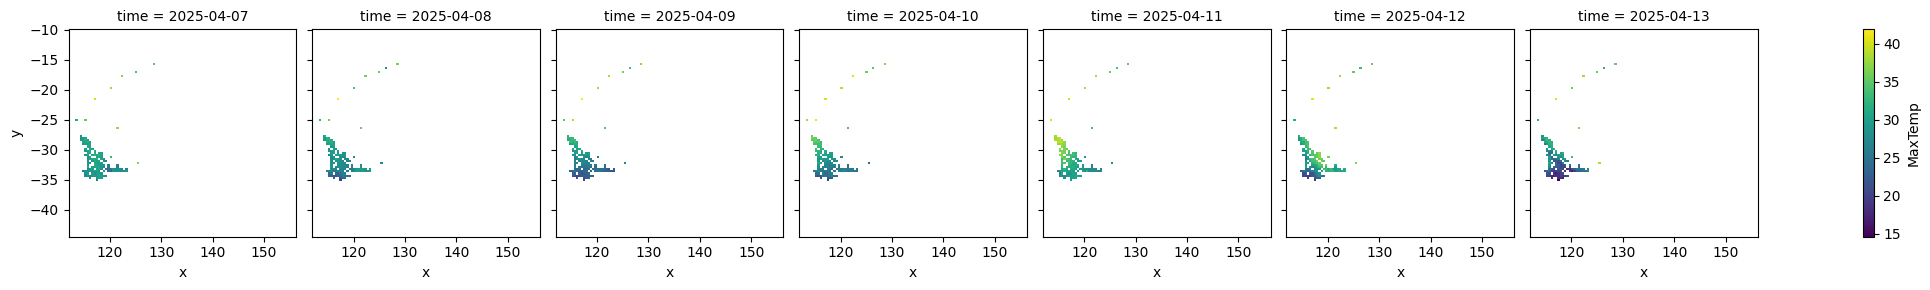

In [51]:
ds["MaxTemp"].coarsen(x=10).mean().coarsen(y=10).mean().plot(x="x", y="y", col="time", col_wrap=7)

Daily minimum air temperatures from weather stations (coarsened to 100*100 so values are visible).

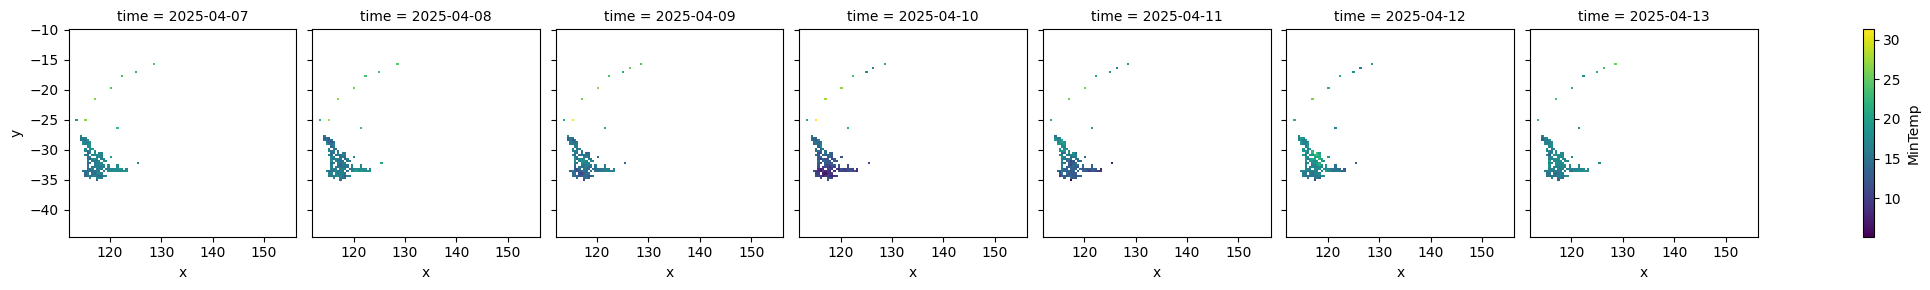

In [52]:
ds["MinTemp"].coarsen(x=10).mean().coarsen(y=10).mean().plot(x="x", y="y", col="time", col_wrap=7)

## Analyse errors
For all points and dates with weather station data, count the number of measured values over the week andcalculate the difference between the measured data and the gridded products.

For each point, calculate the maximum, minimum and mean errors and the standard deviation of the errors for the seven days.

In [53]:
# Calculations for maximum temperatures
ds["max_temp_count"] = ds["MaxTemp"].count(dim="time")
ds["max_temp_count"] = ds["max_temp_count"].where(ds["max_temp_count"] > 0, np.nan)
ds["error_max_temp"] = ds["MaxTemp"].where(ds["MaxTemp"] == np.nan, ds["MaxTemp"] - ds["max_temp_gridded"])
ds["error_max_temp"] = ds["error_max_temp"].where(ds["error_max_temp"] > 0, -ds["error_max_temp"])
ds["mean_error_max_temp"] = ds["error_max_temp"].mean(dim="time")
ds["max_error_max_temp"] = ds["error_max_temp"].max(dim="time")
ds["min_error_max_temp"] = ds["error_max_temp"].min(dim="time")
ds["std_error_max_temp"] = ds["error_max_temp"].std(dim="time")

# Calculations for minimum temperatures
ds["min_temp_count"] = ds["MinTemp"].count(dim="time")
ds["min_temp_count"] = ds["min_temp_count"].where(ds["min_temp_count"] > 0, np.nan)
ds["error_min_temp"] = ds["MinTemp"].where(ds["MinTemp"] == np.nan, ds["MinTemp"] - ds["min_temp_gridded"])
ds["error_min_temp"] = ds["error_min_temp"].where(ds["error_min_temp"] > 0, -ds["error_min_temp"])
ds["mean_error_min_temp"] = ds["error_min_temp"].mean(dim="time")
ds["max_error_min_temp"] = ds["error_min_temp"].max(dim="time")
ds["min_error_min_temp"] = ds["error_min_temp"].min(dim="time")
ds["std_error_min_temp"] = ds["error_min_temp"].std(dim="time")

# Generate pandas dataframe with values for analysis
computed_layers = [
    "max_temp_count",
    "mean_error_max_temp",
    "max_error_max_temp",
    "min_error_max_temp",
    "std_error_max_temp",
    "min_temp_count",
    "mean_error_min_temp",
    "max_error_min_temp",
    "min_error_min_temp",
    "std_error_min_temp"
]
da = ds[["Name"]+computed_layers].to_dataframe().drop(columns="spatial_ref").dropna(axis=0).reset_index()
da = da.loc[da["Name"] > 0].reset_index().drop(columns=["index","time"]).drop_duplicates()

# Restore actual station names
da["Name"] = da["Name"].map(lambda x: ds.attrs["Name"][int(x)])

# Display
da

/home/dhobern/projects/mccn-case-studies/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dhobern/projects/mccn-case-studies/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,y,x,Name,max_temp_count,mean_error_max_temp,max_error_max_temp,min_error_max_temp,std_error_max_temp,min_temp_count,mean_error_min_temp,max_error_min_temp,min_error_min_temp,std_error_min_temp
0,-15.633875,128.66935,Kununurra (KN),7.0,2.592857,3.27,1.96,0.417944,7.0,0.662857,1.35,0.24,0.345738
1,-16.393975,126.41005,DFES-E Gibb River Ap (BTSE),6.0,1.516667,5.17,0.37,1.661181,5.0,2.744000,3.81,0.88,0.987818
2,-17.050425,125.21395,Dulundi (Silent Grove) (SILE),7.0,0.837143,1.17,0.49,0.259379,7.0,1.290000,2.12,0.07,0.799875
3,-17.845075,122.37875,Broome (Skuthorpe) (BR010),7.0,2.561429,3.86,1.25,1.061326,7.0,3.252857,5.40,0.23,1.649742
4,-24.824175,113.69595,Carnarvon 1 (CA),7.0,2.682857,6.22,1.27,1.673360,7.0,0.777143,1.95,0.24,0.537845
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-34.359975,119.32205,Bremer Bay (BY001),7.0,1.275714,2.32,0.44,0.854782,7.0,0.768571,2.12,0.19,0.647797
115,-34.429075,117.46145,Kendenup West (MB002),7.0,1.277143,2.72,0.14,0.866812,7.0,0.697143,1.63,0.03,0.570932
116,-34.567275,118.25885,Kojaneerup South (KO002),7.0,2.144286,3.02,0.26,0.932965,7.0,0.858571,1.99,0.33,0.601603
117,-34.774575,118.21455,Manypeaks (MP),7.0,2.158571,4.41,0.12,1.323183,7.0,3.905714,5.73,1.07,1.343565


## Display results
Map the values for each calculated layer

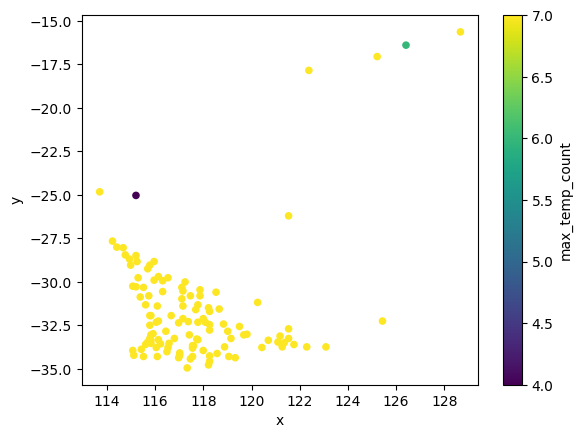

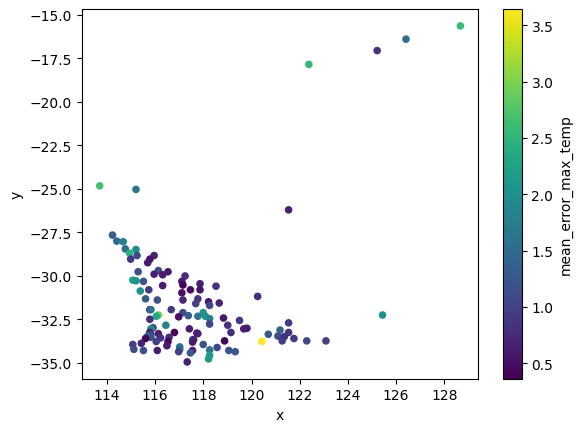

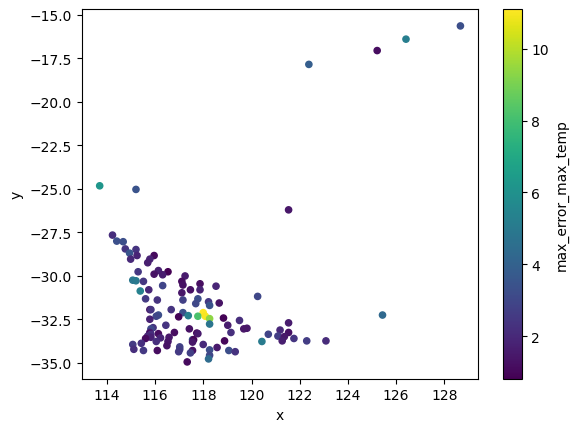

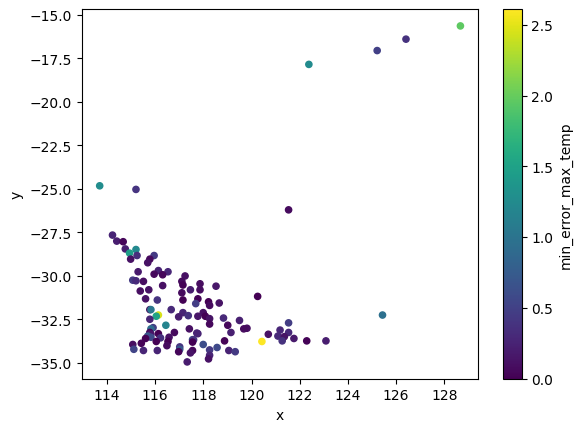

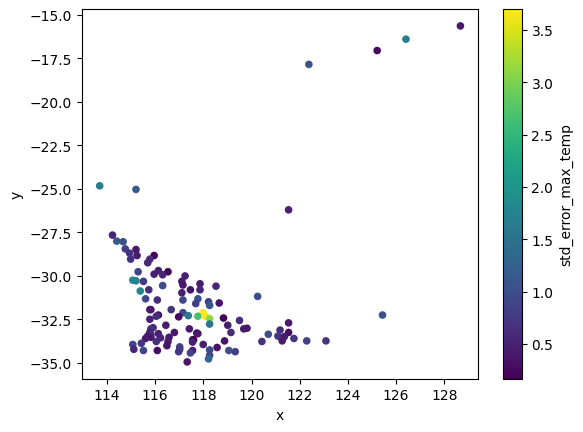

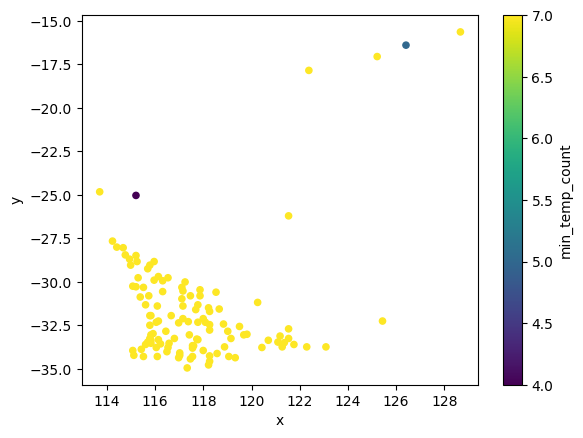

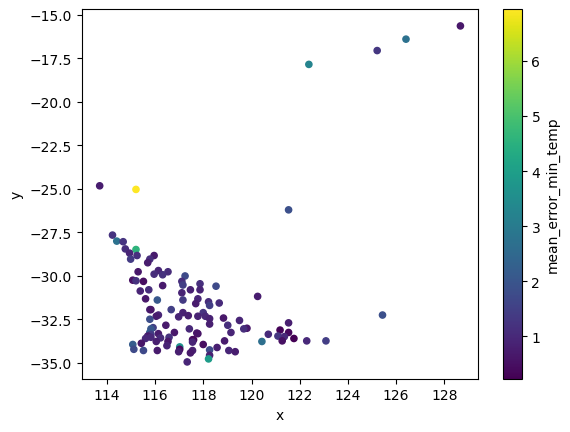

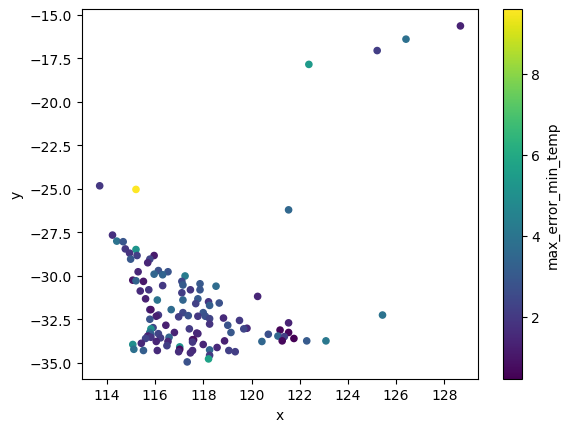

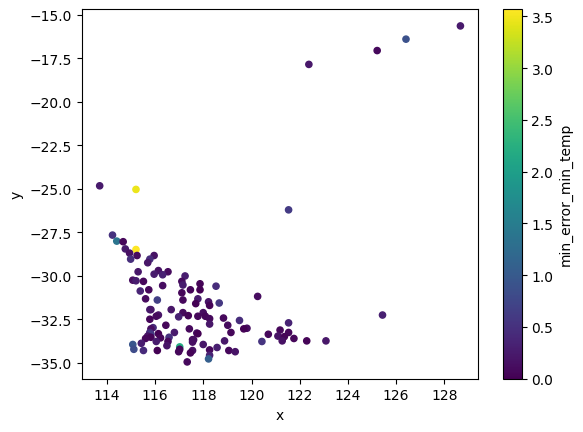

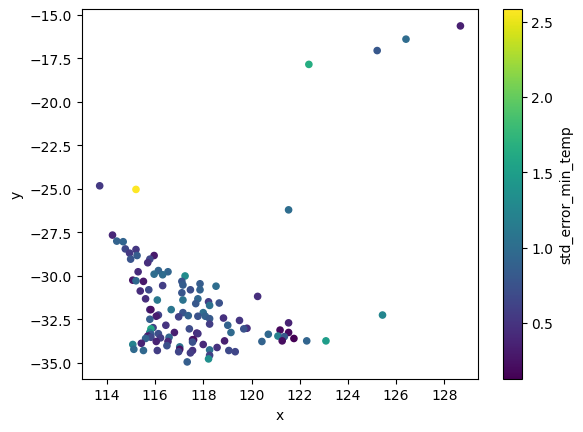

In [54]:
for v in computed_layers:
    da.plot(x="x", y="y", kind="scatter", c=v)

## Sites with high errors for mean maximum temperature
Show details for sites that have one of the three most extreme values for any of the maximum temperature error values. Since most sites show low error values, it is likely that these sites have miscalibrated or poorly positioned sensors.

In [55]:
extreme_cases = set()
max_temp_columns = [c for c in computed_layers if c.endswith("max_temp")]
for v in max_temp_columns:
    extreme_cases |= set(da.sort_values(v, ascending=False).iloc[0:3,].index)
extreme_sites = da.iloc[sorted(list(extreme_cases))][["x","y","Name","max_temp_count"]+max_temp_columns]
pd.merge(extreme_sites, pd.read_csv(weather_maxima_source).drop(columns=["04/04","05/04","06/04"]), how="left", on="Name")

,x,y,Name,max_temp_count,mean_error_max_temp,max_error_max_temp,min_error_max_temp,std_error_max_temp,07/04,08/04,09/04,10/04,11/04,12/04,13/04
0,128.66935,-15.633875,Kununurra (KN),7.0,2.592857,3.27,1.96,0.417944,34.7,36.2,37.2,37.1,35.5,35.6,35.5
1,113.69595,-24.824175,Carnarvon 1 (CA),7.0,2.682857,6.22,1.27,1.673360,31.3,32.3,34.5,38.1,40.0,31.7,31.9
2,117.99305,-32.114225,Babakin (SH002),7.0,2.085714,11.10,0.11,3.691453,29.8,27.2,26.3,26.6,31.2,34.1,20.6
3,116.13245,-32.252425,Glen Eagle (GE001),7.0,2.911429,3.29,2.45,0.314117,29.5,28.9,27.5,30.0,34.4,29.9,28.3
4,118.08165,-32.321525,Corrigin East (CO002),7.0,2.020000,11.00,0.01,3.698397,29.1,28.3,27.2,27.1,31.3,35.1,20.6
5,118.25885,-32.459725,Kondinin (KD001),7.0,1.787143,9.37,0.13,3.115591,28.8,27.4,26.6,26.4,31.5,34.9,20.1
6,120.42955,-33.772625,Jerdacuttup (JP001),7.0,3.642857,5.05,2.61,0.679784,28.7,30.5,26.8,28.7,33.0,35.3,24.2


## Sites with high errors for mean minimum temperature
Show details for sites that have one of the three most extreme values for any of the minimum temperature error values. Since most sites show low error values, it is likely that these sites have miscalibrated or poorly positioned sensors.

In [56]:
extreme_cases = set()
min_temp_columns = [c for c in computed_layers if c.endswith("min_temp")]
for v in max_temp_columns:
    extreme_cases |= set(da.sort_values(v, ascending=False).iloc[0:3,].index)
extreme_sites = da.iloc[sorted(list(extreme_cases))][["x","y","Name","min_temp_count"]+min_temp_columns]
pd.merge(extreme_sites, pd.read_csv(weather_minima_source).drop(columns=["04/04","05/04","06/04"]), how="left", on="Name")

,x,y,Name,min_temp_count,mean_error_min_temp,max_error_min_temp,min_error_min_temp,std_error_min_temp,07/04,08/04,09/04,10/04,11/04,12/04,13/04
0,128.66935,-15.633875,Kununurra (KN),7.0,0.662857,1.35,0.24,0.345738,24.4,24.6,24.2,21.4,19.6,20.3,25.3
1,113.69595,-24.824175,Carnarvon 1 (CA),7.0,0.777143,1.95,0.24,0.537845,19.1,21.4,21.4,20.9,21.9,22.1,22.7
2,117.99305,-32.114225,Babakin (SH002),7.0,1.228571,2.92,0.12,1.011356,17.1,15.4,16.6,11.6,11.8,18.8,17.8
3,116.13245,-32.252425,Glen Eagle (GE001),7.0,0.938571,1.98,0.19,0.613920,15.5,14.8,14.4,11.6,15.0,15.0,16.6
4,118.08165,-32.321525,Corrigin East (CO002),7.0,0.981429,2.74,0.05,0.896460,16.3,15.8,17.4,11.8,11.4,19.4,17.4
5,118.25885,-32.459725,Kondinin (KD001),7.0,0.845714,2.30,0.08,0.814368,17.3,15.7,16.3,12.5,14.3,21.1,17.4
6,120.42955,-33.772625,Jerdacuttup (JP001),7.0,2.655714,3.45,0.54,0.903404,20.4,22.5,18.9,15.9,15.7,19.8,20.8


## Sites with low errors
Show details for sites that show low error values for both maximum and minimum mean temperature. These sites probably represent the best calibrated and positioned sensors and might be useful for future calibration.

In [57]:
da.loc[(da["mean_error_min_temp"] < 0.7) & (da["mean_error_max_temp"] < 0.7)]

,y,x,Name,max_temp_count,mean_error_max_temp,max_error_max_temp,min_error_max_temp,std_error_max_temp,min_temp_count,mean_error_min_temp,max_error_min_temp,min_error_min_temp,std_error_min_temp
58,-32.425175,118.83475,Hyden (HY001),7.0,0.560000,0.88,0.30,0.194936,7.0,0.658571,1.58,0.08,0.469937
67,-33.012525,119.80935,Lake King (LK),7.0,0.624286,1.45,0.10,0.399173,7.0,0.618571,1.51,0.12,0.449775
73,-33.254375,116.79695,Darkan (DK001),7.0,0.400000,1.18,0.07,0.378984,7.0,0.665714,1.38,0.24,0.344999
76,-33.288925,117.72725,Dumbleyung (DU001),7.0,0.648571,1.01,0.25,0.252837,7.0,0.634286,1.41,0.17,0.387809
79,-33.323475,117.77155,Dumbleyung GRDC (DU002),7.0,0.662857,1.51,0.25,0.392127,7.0,0.597143,1.51,0.01,0.496695
91,-33.668975,117.59435,Katanning (KA),7.0,0.674286,0.93,0.38,0.177108,7.0,0.377143,0.85,0.13,0.231622
97,-33.772625,116.53115,Dinninup (DP001),7.0,0.430000,1.39,0.01,0.431045,7.0,0.658571,1.50,0.07,0.413813
100,-33.876275,115.42365,Baudin (Lawson Rd 2) (BAUD),7.0,0.681429,2.23,0.03,0.734194,7.0,0.621429,1.48,0.28,0.371961


## Cleanup
Beware - this will delete all generated files.

In [58]:
# Clean up scratch folder

shutil.rmtree(scratch_folder)